In [7]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
df_train = pd.read_csv("nndata/train.csv")
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_train.isna().sum().sum()

0

El set no tiene datos faltantes.

In [5]:
df_train.mask(df_train.gt(255) & df_train.lt(0))
df_train.isna().sum().sum()

0

También se encontró que ningún pixel se sale del rango esperado

In [3]:
labels = df_train.pop('label')
features = np.array(df_train)
features_train, features_test, labels_train, labels_test = train_test_split(features, 
labels, test_size=0.33, random_state=42)

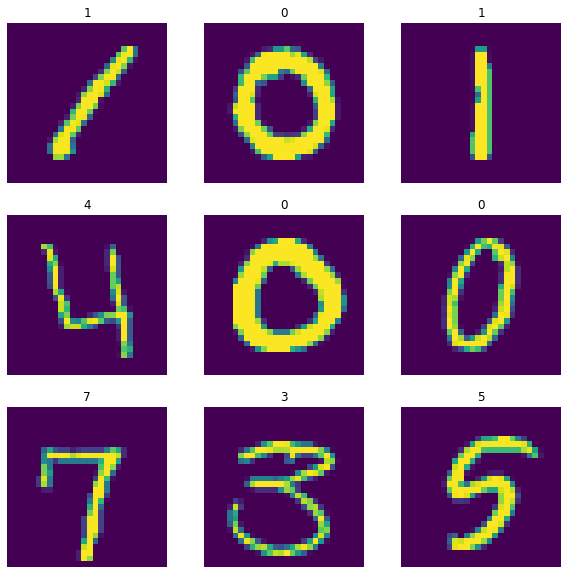

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = np.copy(features[i]).reshape((28,28))
    plt.imshow(img.astype('uint8'))
    plt.title(labels[i])
    plt.axis("off")

In [66]:
print(f'Min: {labels.min()}')
print(f'Max: {labels.max()}')

Min: 0
Max: 9


Al inspeccionar las gráficas y los máximos y mínimos de las labels se puede concluir que, de estar bien clasificados los números, estos van del 0 al 9.

In [173]:
keras.utils.set_random_seed(1234)
NN_simple = keras.Sequential()
NN_simple.bias = 0.5
NN_simple.add(keras.layers.Input(784))
NN_simple.add(keras.layers.Rescaling(1.0/255))

NN_simple.add(keras.layers.Dense(784, activation='relu'))
#NN_simple.add(keras.layers.Dense(392, activation='relu'))
NN_simple.add(keras.layers.Dense(196, activation='relu'))
#NN_simple.add(keras.layers.Dense(98,  activation='relu'))
NN_simple.add(keras.layers.Dense(49,  activation='relu'))

#NN_simple.add(keras.layers.Dropout(.2))


NN_simple.add(keras.layers.Dense(10, activation='softmax'))
NN_simple.output_shape



(None, 10)

In [15]:
#cambiar el formato de las labels para que la NN pueda mostrar las probabilidades de que el número sea tal en vez del valor del número
labels10 = np.zeros(shape=(labels_train.shape[0], 10), dtype=np.float32)
for i, val in enumerate(labels_train):
    labels10[i][val] = 1.0

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

In [174]:
NN_simple.compile( metrics=["accuracy"], 
optimizer = keras.optimizers.Adam(learning_rate=1e-3), 
loss="categorical_crossentropy")

In [175]:
NN_simple.fit(features_train, labels10, epochs=25, callbacks = callbacks)

Epoch 1/25
880/880 [==============================] - 9s 9ms/step - loss: 0.2565 - accuracy: 0.9226
Epoch 2/25
880/880 [==============================] - 8s 9ms/step - loss: 0.1100 - accuracy: 0.9668
Epoch 3/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0711 - accuracy: 0.9767
Epoch 4/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0540 - accuracy: 0.9825
Epoch 5/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0448 - accuracy: 0.9845
Epoch 6/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0368 - accuracy: 0.9883
Epoch 7/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0264 - accuracy: 0.9915
Epoch 8/25
880/880 [==============================] - 8s 10ms/step - loss: 0.0302 - accuracy: 0.9902
Epoch 9/25
880/880 [==============================] - 8s 10ms/step - loss: 0.0232 - accuracy: 0.9927
Epoch 10/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0239 - accuracy: 0.99

In [4]:
NN_simple = keras.models.load_model('save_at_25.h5')
prediction = NN_simple.predict(features_test)

434/434 [==============================] - 4s 8ms/step


In [7]:
prediction.shape

(13860, 10)

In [5]:
results = np.zeros(shape=prediction.shape[0], dtype='uint8')

for i in range(prediction.shape[0]):
    results[i] = int(np.argmax(prediction[i]))

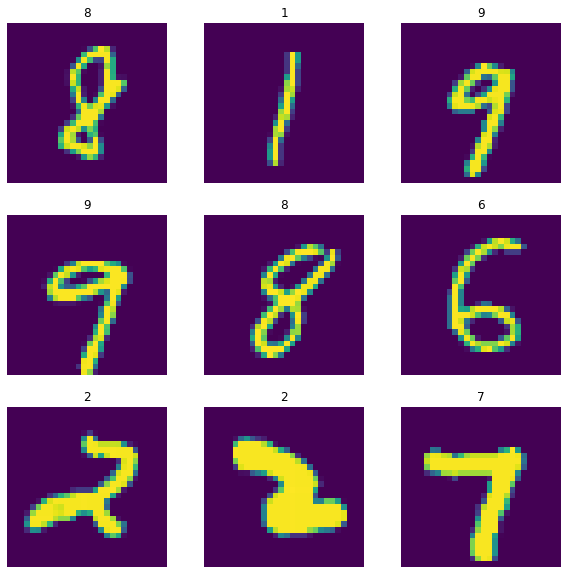

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = np.copy(features_test[i]).reshape((28,28))
    plt.imshow(img.astype('uint8'))
    plt.title(results[i])
    plt.axis("off")

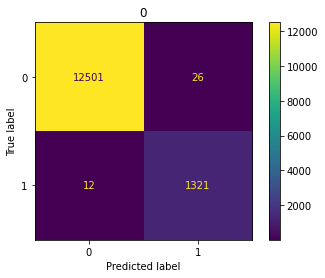

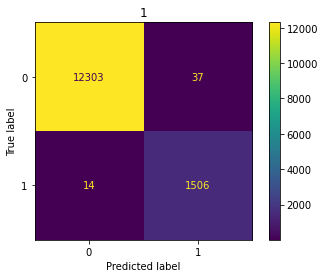

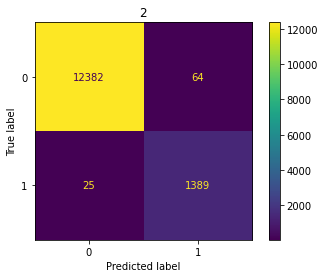

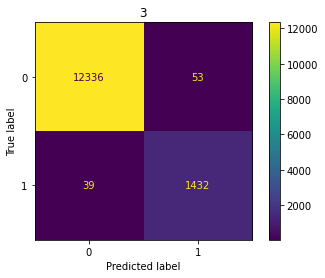

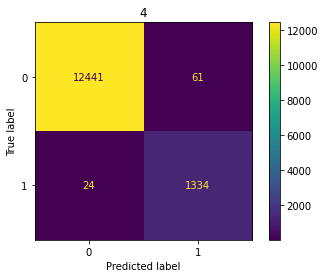

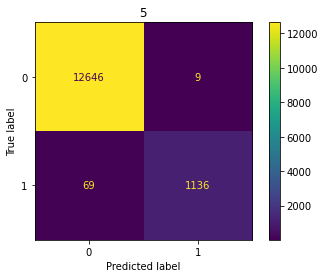

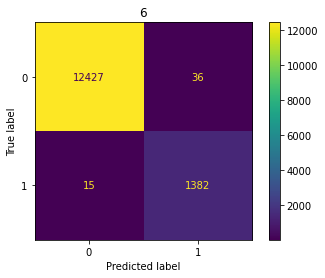

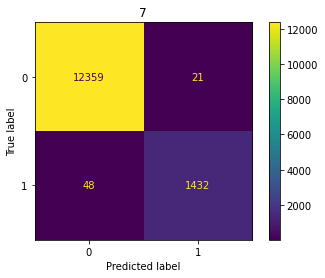

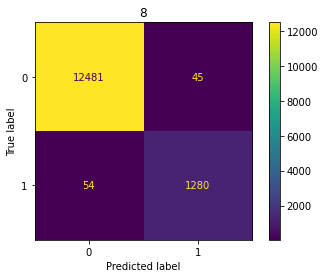

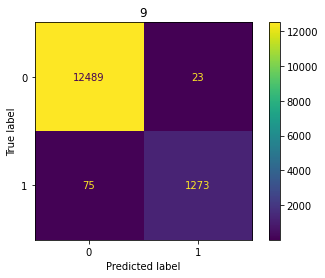

In [11]:
from sklearn import metrics
cf = metrics.multilabel_confusion_matrix(y_true=labels_test, y_pred=results, labels=list(range(10)))
for i, v in enumerate(cf):
    disp = metrics.ConfusionMatrixDisplay(v).plot()
    plt.title(f'{i}')


In [12]:
metrics.accuracy_score(y_true=labels_test, y_pred=results,)

0.9729437229437229

In [8]:
metrics.recall_score(y_true=labels_test, y_pred=results, average='macro')

0.9723372378841122

In [36]:
keras.utils.set_random_seed(1234)
ConvNN = keras.Sequential()
ConvNN.bias = 0.5
ConvNN.add(keras.layers.Input(784))
ConvNN.add(keras.layers.Rescaling(1.0/255))

ConvNN.add(keras.layers.Reshape((28, 28)))

ConvNN.add(keras.layers.Convolution1D(128, (4), strides=(2), activation='relu'))
ConvNN.add(keras.layers.MaxPool1D(2))

ConvNN.add(keras.layers.Convolution1D(64,  (4), strides=(2), activation='relu'))
ConvNN.add(keras.layers.MaxPool1D(2))

ConvNN.add(keras.layers.Flatten())
ConvNN.add(keras.layers.Dense(784, activation='relu'))
ConvNN.add(keras.layers.Dense(196, activation='relu'))
ConvNN.add(keras.layers.Dense(49,  activation='relu'))

ConvNN.add(keras.layers.Dropout(.5))


ConvNN.add(keras.layers.Dense(10, activation='softmax'))
ConvNN.output_shape

(None, 10)

In [33]:
callbacksConv = [
    keras.callbacks.ModelCheckpoint("convNN_save_at_{epoch}.h5"),
]

In [37]:
ConvNN.compile( metrics=["accuracy"], 
optimizer = keras.optimizers.Adam(learning_rate=1e-3), 
loss="categorical_crossentropy")

In [38]:
ConvNN.fit(features_train, labels10, epochs=25, callbacks = callbacksConv)

Epoch 1/25
880/880 [==============================] - 6s 6ms/step - loss: 0.4742 - accuracy: 0.8580
Epoch 2/25
880/880 [==============================] - 5s 6ms/step - loss: 0.1711 - accuracy: 0.9576
Epoch 3/25
880/880 [==============================] - 5s 6ms/step - loss: 0.1211 - accuracy: 0.9706
Epoch 4/25
880/880 [==============================] - 5s 6ms/step - loss: 0.1062 - accuracy: 0.9732
Epoch 5/25
880/880 [==============================] - 6s 6ms/step - loss: 0.0871 - accuracy: 0.9784
Epoch 6/25
880/880 [==============================] - 5s 6ms/step - loss: 0.0723 - accuracy: 0.9821
Epoch 7/25
880/880 [==============================] - 6s 6ms/step - loss: 0.0665 - accuracy: 0.9827
Epoch 8/25
880/880 [==============================] - 5s 6ms/step - loss: 0.0571 - accuracy: 0.9854
Epoch 9/25
880/880 [==============================] - 6s 6ms/step - loss: 0.0465 - accuracy: 0.9871
Epoch 10/25
880/880 [==============================] - 5s 6ms/step - loss: 0.0532 - accuracy: 0.9866

In [10]:
ConvNN = keras.models.load_model('convNN_save_at_25.h5')
prediction_conv = ConvNN.predict(features_test)

434/434 [==============================] - 2s 5ms/step


In [11]:
results_conv = np.zeros(shape=prediction_conv.shape[0], dtype='uint8')

for i in range(prediction_conv.shape[0]):
    results_conv[i] = int(np.argmax(prediction_conv[i]))

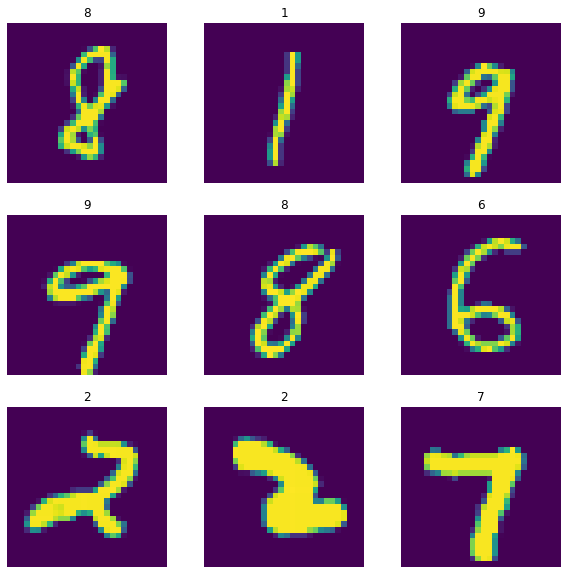

In [42]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = np.copy(features_test[i]).reshape((28,28))
    plt.imshow(img.astype('uint8'))
    plt.title(results_conv[i])
    plt.axis("off")

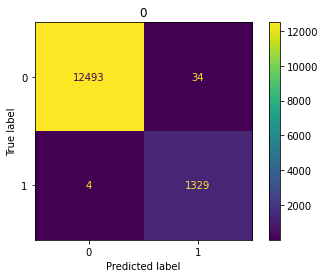

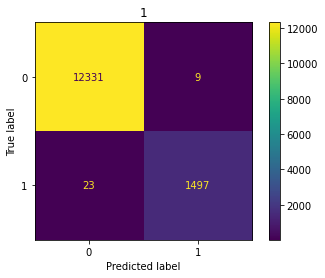

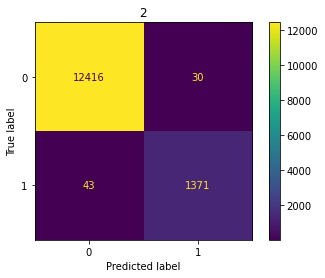

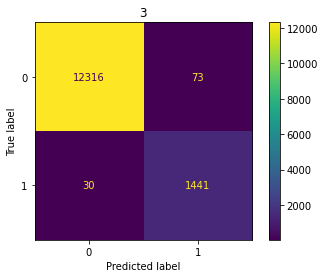

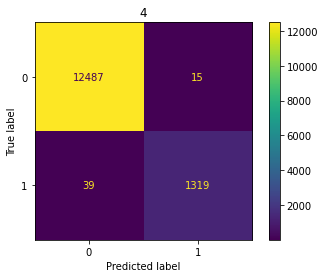

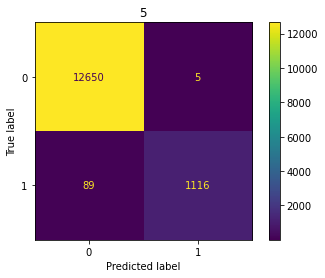

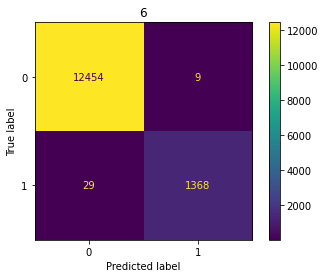

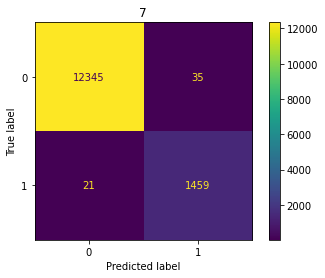

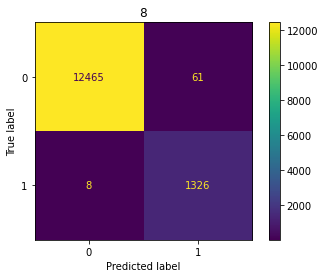

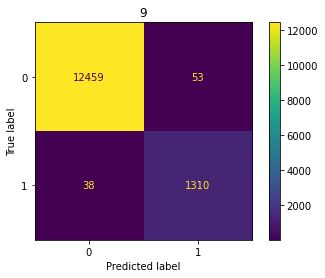

In [45]:
cf = metrics.multilabel_confusion_matrix(y_true=labels_test, y_pred=results_conv, labels=list(range(10)))
for i, v in enumerate(cf):
    disp = metrics.ConfusionMatrixDisplay(v).plot()
    plt.title(f'{i}')

In [12]:
metrics.accuracy_score(y_true=labels_test, y_pred=results_conv,)

0.9766233766233766

In [13]:
metrics.recall_score(y_true=labels_test, y_pred=results, average='macro')

0.9723372378841122